# **CC6204 - Deep Learning**

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [36]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability 
*   delayed healing 
*   partial paresis 
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\]. 

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [324]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv

--2022-09-18 03:06:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34682 (34K) [application/x-httpd-php]
Saving to: ‘diabetes_data_upload.csv.1’

diabetes_data_uploa 100%[===================>]  33,87K   219KB/s    in 0,2s    

2022-09-18 03:06:33 (219 KB/s) - ‘diabetes_data_upload.csv.1’ saved [34682/34682]



In [37]:
dataset_path = 'diabetes_data_upload.csv'

In [38]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [39]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [40]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')


In [41]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20. 
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

## Respuesta


In [42]:
#Packages to use pytorch
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from functools import reduce

import time
import random

In [43]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### Clases necesarias 

In [44]:
class MLP(nn.Module):
  # We need to define two methods at leats: constructor and forward

  #Constructor is for member definitions
  def __init__(self, layers):
    super().__init__()
    self.layers = layers

  #Forward: what happens when we feed the network with data
  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)

    return self.layers(input)

In [64]:
class Model:
    def __init__(self, optimizer, model, criteron, epoch, train_iterator, test_iterator) -> None:
        self.optimizer = optimizer
        self.model = model
        self.criterion = criteron
        self.epoch = epoch

        self.train_iterator = train_iterator
        self.test_iterator = test_iterator

        self.init_device()

    def init_device(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.model = self.model.to(self.device)
        self.criterion = self.criterion.to(self.device)

    def calculate_accuracy(self, y_pred, y):
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float()/y.shape[0]
        return acc

    def train(self):
        epoch_loss = 0
        epoch_acc = 0

        #We have to set the neural network in training mode. This is because during
        #training, we need gradients and complementary data to ease the computation  
        self.model.train()

        #Training loop
        for (x, y) in self.train_iterator:
            x = x.to(self.device) #Data
            y = y.to(self.device) #Labels
                
            self.optimizer.zero_grad() #Clean gradients
                     
            y_pred = self.model(x) #Feed the network with data

            loss = self.criterion(y_pred, y) #Compute the loss
               
            acc = self.calculate_accuracy(y_pred, y) #Compute the accuracy
                
            loss.backward() #Compute gradients
                
            self.optimizer.step() #Apply update rules
                
            epoch_loss += loss.item()
            epoch_acc += acc.item()
                
        return epoch_loss / len(self.train_iterator), epoch_acc / len(self.train_iterator)

    def evaluate(self):
        epoch_loss = 0
        epoch_acc = 0
        
        # We put the network in testing mode
        #In this mode, Pytorch doesn't use features only reserved for 
        #training (dropout for instance)    
        self.model.eval()

        with torch.no_grad(): #disable the autograd engine (save computation and memory)
            for (x, y) in self.test_iterator:
                x = x.to(self.device)
                y = y.to(self.device)

                y_pred = self.model(x)

                loss = self.criterion(y_pred, y)

                acc = self.calculate_accuracy(y_pred, y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

        return epoch_loss / len(self.test_iterator), epoch_acc / len(self.test_iterator)


    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def run(self, print_epoch=True):
        
        y_train = np.zeros(self.epoch)
        y_test = np.zeros(self.epoch)
        
        for epoch in range(self.epoch):
    
            start_time = time.time()
            
            #Train + validation cycles  
            train_loss, train_acc = self.train()
            test_loss, test_acc = self.evaluate()
            
            y_train[epoch] = train_loss
            y_test[epoch] = test_loss
            

            if print_epoch:
                end_time = time.time()

                epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)
                
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')
                
        return [y_train, y_test]



#### Creación datasets train y test

In [46]:
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train.flatten()).long()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test.flatten()).long()

train_data = list(zip(X_train, Y_train))
test_data = list(zip(X_test, Y_test))

#### Creación hiperparámetros y modelo

In [73]:
def create_all(batch_size=20, learning_rate=0.01):
    INPUT_DIM = 16
    OUTPUT_DIM = 2
    
    layers = nn.Sequential(
        nn.Linear(INPUT_DIM, 8),
        nn.ReLU(),
        nn.Linear(8, 4),
        nn.ReLU(),
        nn.Linear(4, OUTPUT_DIM)
    )
    
    model = MLP(layers)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    BATCH_SIZE = batch_size
    train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
    test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)
    EPOCH = 400
    
    simplest_model = Model(optimizer, model, criterion, EPOCH, train_iterator, test_iterator)
    data_list = simplest_model.run()
    return data_list


In [99]:
def plot_epoch_vs_loss(data_list, title):
    y_train = data_list[0]
    y_test = data_list[1]
    
    plt.figure(figsize=(14,10))
    plt.plot(y_train, color='b', label="Train Loss")
    plt.plot(y_test, color='r', label="Test loss")
    
    plt.ylim((0, 0.9))
    plt.xlabel("Número de época", fontsize=20)
    plt.ylabel("Valor función loss", fontsize=20)
    plt.title(title,fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

In [93]:
data_list = create_all()

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.751 | Train Acc: 38.49%
	 Val. Loss: 0.748 |  Test. Acc: 36.67%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.733 | Train Acc: 38.49%
	 Val. Loss: 0.730 |  Test. Acc: 36.67%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.719 | Train Acc: 38.25%
	 Val. Loss: 0.715 |  Test. Acc: 36.67%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.706 | Train Acc: 38.73%
	 Val. Loss: 0.704 |  Test. Acc: 37.50%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.696 | Train Acc: 43.41%
	 Val. Loss: 0.694 |  Test. Acc: 52.50%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 57.86%
	 Val. Loss: 0.686 |  Test. Acc: 63.33%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.682 | Train Acc: 61.51%
	 Val. Loss: 0.679 |  Test. Acc: 63.33%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.676 | Train Acc: 61.51%
	 Val. Loss: 0.674 |  Test. Acc: 63.33%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.671 | Train Acc: 61.67%
	 Val. Loss: 0.669 |  Test. Acc: 63.33%
Epoch: 10 | Epoch T

Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.242 | Train Acc: 91.11%
	 Val. Loss: 0.244 |  Test. Acc: 88.33%
Epoch: 81 | Epoch Time: 0m 0s
	Train Loss: 0.241 | Train Acc: 91.51%
	 Val. Loss: 0.242 |  Test. Acc: 88.33%
Epoch: 82 | Epoch Time: 0m 0s
	Train Loss: 0.238 | Train Acc: 91.83%
	 Val. Loss: 0.241 |  Test. Acc: 88.33%
Epoch: 83 | Epoch Time: 0m 0s
	Train Loss: 0.236 | Train Acc: 91.83%
	 Val. Loss: 0.238 |  Test. Acc: 88.33%
Epoch: 84 | Epoch Time: 0m 0s
	Train Loss: 0.234 | Train Acc: 91.75%
	 Val. Loss: 0.236 |  Test. Acc: 89.17%
Epoch: 85 | Epoch Time: 0m 0s
	Train Loss: 0.232 | Train Acc: 91.90%
	 Val. Loss: 0.234 |  Test. Acc: 89.17%
Epoch: 86 | Epoch Time: 0m 0s
	Train Loss: 0.229 | Train Acc: 91.83%
	 Val. Loss: 0.232 |  Test. Acc: 89.17%
Epoch: 87 | Epoch Time: 0m 0s
	Train Loss: 0.228 | Train Acc: 92.22%
	 Val. Loss: 0.230 |  Test. Acc: 89.17%
Epoch: 88 | Epoch Time: 0m 0s
	Train Loss: 0.225 | Train Acc: 92.06%
	 Val. Loss: 0.229 |  Test. Acc: 89.17%
Epoch: 89 | Epoch T

Epoch: 161 | Epoch Time: 0m 0s
	Train Loss: 0.159 | Train Acc: 94.92%
	 Val. Loss: 0.183 |  Test. Acc: 95.00%
Epoch: 162 | Epoch Time: 0m 0s
	Train Loss: 0.158 | Train Acc: 94.92%
	 Val. Loss: 0.182 |  Test. Acc: 95.00%
Epoch: 163 | Epoch Time: 0m 0s
	Train Loss: 0.157 | Train Acc: 94.92%
	 Val. Loss: 0.182 |  Test. Acc: 95.00%
Epoch: 164 | Epoch Time: 0m 0s
	Train Loss: 0.158 | Train Acc: 94.92%
	 Val. Loss: 0.182 |  Test. Acc: 95.00%
Epoch: 165 | Epoch Time: 0m 0s
	Train Loss: 0.158 | Train Acc: 94.92%
	 Val. Loss: 0.183 |  Test. Acc: 95.00%
Epoch: 166 | Epoch Time: 0m 0s
	Train Loss: 0.158 | Train Acc: 94.92%
	 Val. Loss: 0.182 |  Test. Acc: 95.00%
Epoch: 167 | Epoch Time: 0m 0s
	Train Loss: 0.157 | Train Acc: 94.92%
	 Val. Loss: 0.182 |  Test. Acc: 95.00%
Epoch: 168 | Epoch Time: 0m 0s
	Train Loss: 0.157 | Train Acc: 94.92%
	 Val. Loss: 0.181 |  Test. Acc: 95.00%
Epoch: 169 | Epoch Time: 0m 0s
	Train Loss: 0.157 | Train Acc: 94.84%
	 Val. Loss: 0.182 |  Test. Acc: 95.00%
Epoch: 170

Epoch: 237 | Epoch Time: 0m 0s
	Train Loss: 0.135 | Train Acc: 95.95%
	 Val. Loss: 0.178 |  Test. Acc: 93.33%
Epoch: 238 | Epoch Time: 0m 0s
	Train Loss: 0.135 | Train Acc: 95.95%
	 Val. Loss: 0.177 |  Test. Acc: 94.17%
Epoch: 239 | Epoch Time: 0m 0s
	Train Loss: 0.134 | Train Acc: 95.95%
	 Val. Loss: 0.178 |  Test. Acc: 93.33%
Epoch: 240 | Epoch Time: 0m 0s
	Train Loss: 0.134 | Train Acc: 96.43%
	 Val. Loss: 0.178 |  Test. Acc: 92.50%
Epoch: 241 | Epoch Time: 0m 0s
	Train Loss: 0.134 | Train Acc: 95.95%
	 Val. Loss: 0.177 |  Test. Acc: 93.33%
Epoch: 242 | Epoch Time: 0m 0s
	Train Loss: 0.136 | Train Acc: 96.11%
	 Val. Loss: 0.179 |  Test. Acc: 92.50%
Epoch: 243 | Epoch Time: 0m 0s
	Train Loss: 0.133 | Train Acc: 96.19%
	 Val. Loss: 0.179 |  Test. Acc: 92.50%
Epoch: 244 | Epoch Time: 0m 0s
	Train Loss: 0.134 | Train Acc: 96.43%
	 Val. Loss: 0.178 |  Test. Acc: 92.50%
Epoch: 245 | Epoch Time: 0m 0s
	Train Loss: 0.132 | Train Acc: 96.43%
	 Val. Loss: 0.178 |  Test. Acc: 92.50%
Epoch: 246

Epoch: 312 | Epoch Time: 0m 0s
	Train Loss: 0.118 | Train Acc: 96.43%
	 Val. Loss: 0.174 |  Test. Acc: 94.17%
Epoch: 313 | Epoch Time: 0m 0s
	Train Loss: 0.120 | Train Acc: 96.27%
	 Val. Loss: 0.176 |  Test. Acc: 93.33%
Epoch: 314 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 96.43%
	 Val. Loss: 0.177 |  Test. Acc: 93.33%
Epoch: 315 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 96.43%
	 Val. Loss: 0.180 |  Test. Acc: 93.33%
Epoch: 316 | Epoch Time: 0m 0s
	Train Loss: 0.118 | Train Acc: 96.59%
	 Val. Loss: 0.180 |  Test. Acc: 93.33%
Epoch: 317 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 96.43%
	 Val. Loss: 0.177 |  Test. Acc: 93.33%
Epoch: 318 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 96.43%
	 Val. Loss: 0.179 |  Test. Acc: 93.33%
Epoch: 319 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 96.43%
	 Val. Loss: 0.179 |  Test. Acc: 93.33%
Epoch: 320 | Epoch Time: 0m 0s
	Train Loss: 0.116 | Train Acc: 96.43%
	 Val. Loss: 0.177 |  Test. Acc: 93.33%
Epoch: 321

Epoch: 390 | Epoch Time: 0m 0s
	Train Loss: 0.103 | Train Acc: 97.14%
	 Val. Loss: 0.171 |  Test. Acc: 95.00%
Epoch: 391 | Epoch Time: 0m 0s
	Train Loss: 0.102 | Train Acc: 96.67%
	 Val. Loss: 0.170 |  Test. Acc: 95.00%
Epoch: 392 | Epoch Time: 0m 0s
	Train Loss: 0.104 | Train Acc: 97.06%
	 Val. Loss: 0.172 |  Test. Acc: 93.33%
Epoch: 393 | Epoch Time: 0m 0s
	Train Loss: 0.102 | Train Acc: 96.90%
	 Val. Loss: 0.170 |  Test. Acc: 95.00%
Epoch: 394 | Epoch Time: 0m 0s
	Train Loss: 0.104 | Train Acc: 96.83%
	 Val. Loss: 0.170 |  Test. Acc: 95.00%
Epoch: 395 | Epoch Time: 0m 0s
	Train Loss: 0.104 | Train Acc: 97.06%
	 Val. Loss: 0.170 |  Test. Acc: 95.00%
Epoch: 396 | Epoch Time: 0m 0s
	Train Loss: 0.102 | Train Acc: 96.90%
	 Val. Loss: 0.170 |  Test. Acc: 95.00%
Epoch: 397 | Epoch Time: 0m 0s
	Train Loss: 0.101 | Train Acc: 96.90%
	 Val. Loss: 0.169 |  Test. Acc: 95.00%
Epoch: 398 | Epoch Time: 0m 0s
	Train Loss: 0.101 | Train Acc: 96.90%
	 Val. Loss: 0.170 |  Test. Acc: 95.00%
Epoch: 399

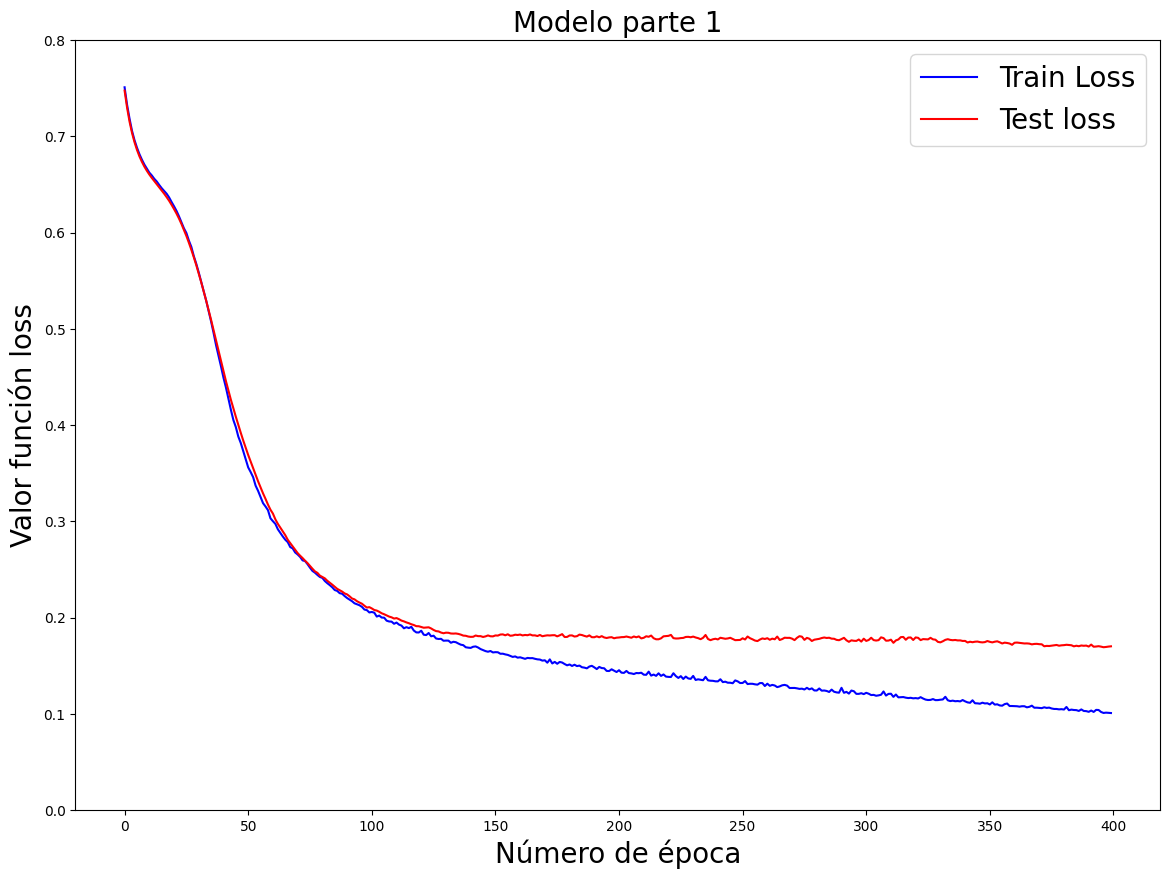

In [94]:
plot_epoch_vs_loss(data_list, "Modelo parte 1")

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

#### Batch Size: m=1

In [95]:
data_list = create_all(batch_size=1)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.671 | Train Acc: 61.45%
	 Val. Loss: 0.666 |  Test. Acc: 61.54%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.667 | Train Acc: 61.45%
	 Val. Loss: 0.663 |  Test. Acc: 61.54%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 61.45%
	 Val. Loss: 0.641 |  Test. Acc: 61.54%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.601 | Train Acc: 61.45%
	 Val. Loss: 0.506 |  Test. Acc: 61.54%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.417 | Train Acc: 79.52%
	 Val. Loss: 0.317 |  Test. Acc: 93.27%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.289 | Train Acc: 91.08%
	 Val. Loss: 0.232 |  Test. Acc: 94.23%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.238 | Train Acc: 91.33%
	 Val. Loss: 0.242 |  Test. Acc: 92.31%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.207 | Train Acc: 94.94%
	 Val. Loss: 0.179 |  Test. Acc: 93.27%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.191 | Train Acc: 94.46%
	 Val. Loss: 0.190 |  Test. Acc: 93.27%
Epoch: 10 | Epoch T

Epoch: 77 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.28%
	 Val. Loss: 0.090 |  Test. Acc: 97.12%
Epoch: 78 | Epoch Time: 0m 0s
	Train Loss: 0.039 | Train Acc: 99.04%
	 Val. Loss: 0.094 |  Test. Acc: 97.12%
Epoch: 79 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.04%
	 Val. Loss: 0.100 |  Test. Acc: 97.12%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.039 | Train Acc: 99.04%
	 Val. Loss: 0.099 |  Test. Acc: 97.12%
Epoch: 81 | Epoch Time: 0m 0s
	Train Loss: 0.039 | Train Acc: 99.04%
	 Val. Loss: 0.092 |  Test. Acc: 97.12%
Epoch: 82 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.04%
	 Val. Loss: 0.100 |  Test. Acc: 97.12%
Epoch: 83 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.04%
	 Val. Loss: 0.105 |  Test. Acc: 97.12%
Epoch: 84 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.28%
	 Val. Loss: 0.085 |  Test. Acc: 97.12%
Epoch: 85 | Epoch Time: 0m 0s
	Train Loss: 0.039 | Train Acc: 98.80%
	 Val. Loss: 0.100 |  Test. Acc: 97.12%
Epoch: 86 | Epoch T

Epoch: 152 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.090 |  Test. Acc: 97.12%
Epoch: 153 | Epoch Time: 0m 0s
	Train Loss: 0.039 | Train Acc: 98.80%
	 Val. Loss: 0.087 |  Test. Acc: 97.12%
Epoch: 154 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.106 |  Test. Acc: 97.12%
Epoch: 155 | Epoch Time: 0m 0s
	Train Loss: 0.037 | Train Acc: 99.04%
	 Val. Loss: 0.099 |  Test. Acc: 97.12%
Epoch: 156 | Epoch Time: 0m 0s
	Train Loss: 0.037 | Train Acc: 99.04%
	 Val. Loss: 0.101 |  Test. Acc: 97.12%
Epoch: 157 | Epoch Time: 0m 0s
	Train Loss: 0.037 | Train Acc: 99.04%
	 Val. Loss: 0.096 |  Test. Acc: 97.12%
Epoch: 158 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.108 |  Test. Acc: 97.12%
Epoch: 159 | Epoch Time: 0m 0s
	Train Loss: 0.038 | Train Acc: 99.04%
	 Val. Loss: 0.096 |  Test. Acc: 97.12%
Epoch: 160 | Epoch Time: 0m 0s
	Train Loss: 0.037 | Train Acc: 99.04%
	 Val. Loss: 0.103 |  Test. Acc: 97.12%
Epoch: 161

Epoch: 227 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.097 |  Test. Acc: 97.12%
Epoch: 228 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.28%
	 Val. Loss: 0.088 |  Test. Acc: 97.12%
Epoch: 229 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.099 |  Test. Acc: 97.12%
Epoch: 230 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.088 |  Test. Acc: 97.12%
Epoch: 231 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.087 |  Test. Acc: 97.12%
Epoch: 232 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.088 |  Test. Acc: 97.12%
Epoch: 233 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.094 |  Test. Acc: 97.12%
Epoch: 234 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.103 |  Test. Acc: 97.12%
Epoch: 235 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.091 |  Test. Acc: 97.12%
Epoch: 236

Epoch: 302 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.088 |  Test. Acc: 97.12%
Epoch: 303 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.097 |  Test. Acc: 97.12%
Epoch: 304 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.100 |  Test. Acc: 97.12%
Epoch: 305 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.28%
	 Val. Loss: 0.094 |  Test. Acc: 97.12%
Epoch: 306 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.097 |  Test. Acc: 97.12%
Epoch: 307 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.087 |  Test. Acc: 97.12%
Epoch: 308 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.096 |  Test. Acc: 97.12%
Epoch: 309 | Epoch Time: 0m 0s
	Train Loss: 0.034 | Train Acc: 99.28%
	 Val. Loss: 0.083 |  Test. Acc: 96.15%
Epoch: 310 | Epoch Time: 0m 0s
	Train Loss: 0.033 | Train Acc: 99.04%
	 Val. Loss: 0.099 |  Test. Acc: 97.12%
Epoch: 311

Epoch: 377 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.097 |  Test. Acc: 97.12%
Epoch: 378 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.097 |  Test. Acc: 97.12%
Epoch: 379 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.093 |  Test. Acc: 97.12%
Epoch: 380 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.28%
	 Val. Loss: 0.093 |  Test. Acc: 97.12%
Epoch: 381 | Epoch Time: 0m 0s
	Train Loss: 0.034 | Train Acc: 99.28%
	 Val. Loss: 0.083 |  Test. Acc: 96.15%
Epoch: 382 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.095 |  Test. Acc: 97.12%
Epoch: 383 | Epoch Time: 0m 0s
	Train Loss: 0.035 | Train Acc: 99.04%
	 Val. Loss: 0.098 |  Test. Acc: 97.12%
Epoch: 384 | Epoch Time: 0m 0s
	Train Loss: 0.034 | Train Acc: 99.28%
	 Val. Loss: 0.084 |  Test. Acc: 96.15%
Epoch: 385 | Epoch Time: 0m 0s
	Train Loss: 0.036 | Train Acc: 99.04%
	 Val. Loss: 0.092 |  Test. Acc: 97.12%
Epoch: 386

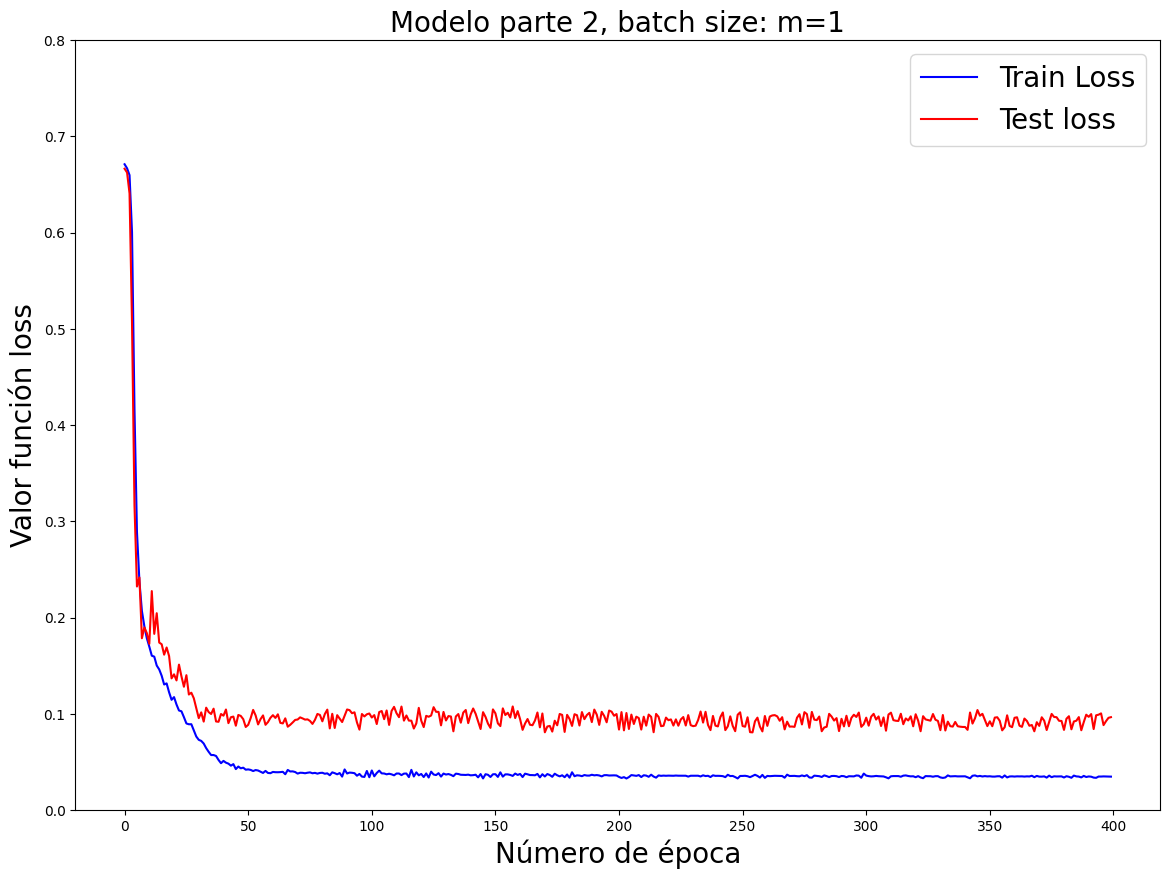

In [96]:
plot_epoch_vs_loss(data_list, "Modelo parte 2, batch size: m=1")

In [97]:
data_list = create_all(batch_size=len(train_data))

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.850 | Train Acc: 38.55%
	 Val. Loss: 0.847 |  Test. Acc: 38.46%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.846 | Train Acc: 38.55%
	 Val. Loss: 0.842 |  Test. Acc: 38.46%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.841 | Train Acc: 38.55%
	 Val. Loss: 0.838 |  Test. Acc: 38.46%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.837 | Train Acc: 38.55%
	 Val. Loss: 0.834 |  Test. Acc: 38.46%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.833 | Train Acc: 38.55%
	 Val. Loss: 0.830 |  Test. Acc: 38.46%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.829 | Train Acc: 38.55%
	 Val. Loss: 0.826 |  Test. Acc: 38.46%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.825 | Train Acc: 38.55%
	 Val. Loss: 0.823 |  Test. Acc: 38.46%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.821 | Train Acc: 38.55%
	 Val. Loss: 0.819 |  Test. Acc: 38.46%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.818 | Train Acc: 38.55%
	 Val. Loss: 0.815 |  Test. Acc: 38.46%
Epoch: 10 | Epoch T

Epoch: 77 | Epoch Time: 0m 0s
	Train Loss: 0.668 | Train Acc: 73.98%
	 Val. Loss: 0.670 |  Test. Acc: 69.23%
Epoch: 78 | Epoch Time: 0m 0s
	Train Loss: 0.667 | Train Acc: 75.18%
	 Val. Loss: 0.669 |  Test. Acc: 70.19%
Epoch: 79 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 75.66%
	 Val. Loss: 0.667 |  Test. Acc: 74.04%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 76.63%
	 Val. Loss: 0.666 |  Test. Acc: 75.00%
Epoch: 81 | Epoch Time: 0m 0s
	Train Loss: 0.663 | Train Acc: 78.07%
	 Val. Loss: 0.665 |  Test. Acc: 75.96%
Epoch: 82 | Epoch Time: 0m 0s
	Train Loss: 0.662 | Train Acc: 78.80%
	 Val. Loss: 0.663 |  Test. Acc: 76.92%
Epoch: 83 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 80.96%
	 Val. Loss: 0.662 |  Test. Acc: 76.92%
Epoch: 84 | Epoch Time: 0m 0s
	Train Loss: 0.659 | Train Acc: 81.93%
	 Val. Loss: 0.661 |  Test. Acc: 78.85%
Epoch: 85 | Epoch Time: 0m 0s
	Train Loss: 0.658 | Train Acc: 82.65%
	 Val. Loss: 0.660 |  Test. Acc: 80.77%
Epoch: 86 | Epoch T

Epoch: 158 | Epoch Time: 0m 0s
	Train Loss: 0.590 | Train Acc: 61.45%
	 Val. Loss: 0.591 |  Test. Acc: 61.54%
Epoch: 159 | Epoch Time: 0m 0s
	Train Loss: 0.589 | Train Acc: 61.45%
	 Val. Loss: 0.590 |  Test. Acc: 61.54%
Epoch: 160 | Epoch Time: 0m 0s
	Train Loss: 0.589 | Train Acc: 61.45%
	 Val. Loss: 0.590 |  Test. Acc: 61.54%
Epoch: 161 | Epoch Time: 0m 0s
	Train Loss: 0.588 | Train Acc: 61.45%
	 Val. Loss: 0.589 |  Test. Acc: 61.54%
Epoch: 162 | Epoch Time: 0m 0s
	Train Loss: 0.587 | Train Acc: 61.45%
	 Val. Loss: 0.588 |  Test. Acc: 61.54%
Epoch: 163 | Epoch Time: 0m 0s
	Train Loss: 0.587 | Train Acc: 61.45%
	 Val. Loss: 0.588 |  Test. Acc: 61.54%
Epoch: 164 | Epoch Time: 0m 0s
	Train Loss: 0.586 | Train Acc: 61.45%
	 Val. Loss: 0.587 |  Test. Acc: 61.54%
Epoch: 165 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 61.45%
	 Val. Loss: 0.586 |  Test. Acc: 61.54%
Epoch: 166 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 61.45%
	 Val. Loss: 0.585 |  Test. Acc: 61.54%
Epoch: 167

Epoch: 248 | Epoch Time: 0m 0s
	Train Loss: 0.539 | Train Acc: 61.45%
	 Val. Loss: 0.538 |  Test. Acc: 61.54%
Epoch: 249 | Epoch Time: 0m 0s
	Train Loss: 0.539 | Train Acc: 61.45%
	 Val. Loss: 0.537 |  Test. Acc: 61.54%
Epoch: 250 | Epoch Time: 0m 0s
	Train Loss: 0.538 | Train Acc: 61.45%
	 Val. Loss: 0.537 |  Test. Acc: 61.54%
Epoch: 251 | Epoch Time: 0m 0s
	Train Loss: 0.538 | Train Acc: 61.45%
	 Val. Loss: 0.536 |  Test. Acc: 61.54%
Epoch: 252 | Epoch Time: 0m 0s
	Train Loss: 0.537 | Train Acc: 61.45%
	 Val. Loss: 0.536 |  Test. Acc: 61.54%
Epoch: 253 | Epoch Time: 0m 0s
	Train Loss: 0.537 | Train Acc: 61.45%
	 Val. Loss: 0.535 |  Test. Acc: 61.54%
Epoch: 254 | Epoch Time: 0m 0s
	Train Loss: 0.536 | Train Acc: 61.45%
	 Val. Loss: 0.534 |  Test. Acc: 61.54%
Epoch: 255 | Epoch Time: 0m 0s
	Train Loss: 0.536 | Train Acc: 61.45%
	 Val. Loss: 0.534 |  Test. Acc: 61.54%
Epoch: 256 | Epoch Time: 0m 0s
	Train Loss: 0.535 | Train Acc: 61.45%
	 Val. Loss: 0.533 |  Test. Acc: 61.54%
Epoch: 257

Epoch: 326 | Epoch Time: 0m 0s
	Train Loss: 0.499 | Train Acc: 63.37%
	 Val. Loss: 0.497 |  Test. Acc: 63.46%
Epoch: 327 | Epoch Time: 0m 0s
	Train Loss: 0.498 | Train Acc: 63.37%
	 Val. Loss: 0.496 |  Test. Acc: 63.46%
Epoch: 328 | Epoch Time: 0m 0s
	Train Loss: 0.498 | Train Acc: 63.37%
	 Val. Loss: 0.495 |  Test. Acc: 63.46%
Epoch: 329 | Epoch Time: 0m 0s
	Train Loss: 0.497 | Train Acc: 63.37%
	 Val. Loss: 0.495 |  Test. Acc: 63.46%
Epoch: 330 | Epoch Time: 0m 0s
	Train Loss: 0.497 | Train Acc: 63.37%
	 Val. Loss: 0.494 |  Test. Acc: 63.46%
Epoch: 331 | Epoch Time: 0m 0s
	Train Loss: 0.496 | Train Acc: 63.37%
	 Val. Loss: 0.494 |  Test. Acc: 63.46%
Epoch: 332 | Epoch Time: 0m 0s
	Train Loss: 0.496 | Train Acc: 63.37%
	 Val. Loss: 0.493 |  Test. Acc: 63.46%
Epoch: 333 | Epoch Time: 0m 0s
	Train Loss: 0.495 | Train Acc: 63.37%
	 Val. Loss: 0.493 |  Test. Acc: 63.46%
Epoch: 334 | Epoch Time: 0m 0s
	Train Loss: 0.495 | Train Acc: 63.37%
	 Val. Loss: 0.492 |  Test. Acc: 63.46%
Epoch: 335

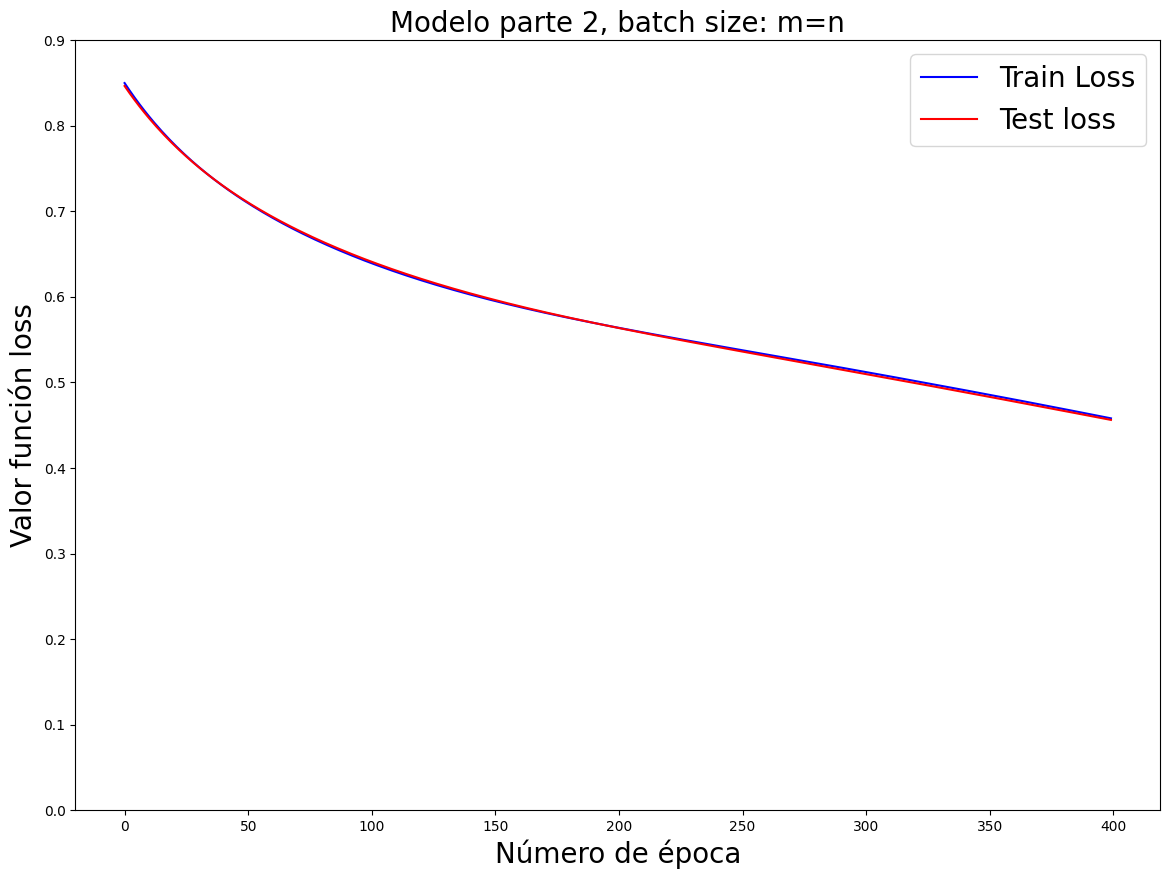

In [100]:
plot_epoch_vs_loss(data_list, "Modelo parte 2, batch size: m=n")

# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [101]:
data_list = create_all(learning_rate=0.5)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.577 | Train Acc: 67.38%
	 Val. Loss: 0.389 |  Test. Acc: 80.83%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.272 | Train Acc: 88.81%
	 Val. Loss: 0.188 |  Test. Acc: 91.67%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.214 | Train Acc: 92.62%
	 Val. Loss: 0.168 |  Test. Acc: 95.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.176 | Train Acc: 94.44%
	 Val. Loss: 0.199 |  Test. Acc: 90.83%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.182 | Train Acc: 93.73%
	 Val. Loss: 0.238 |  Test. Acc: 89.17%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.184 | Train Acc: 94.05%
	 Val. Loss: 0.242 |  Test. Acc: 92.50%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.165 | Train Acc: 94.76%
	 Val. Loss: 0.170 |  Test. Acc: 90.00%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.158 | Train Acc: 94.68%
	 Val. Loss: 0.157 |  Test. Acc: 95.00%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.143 | Train Acc: 95.71%
	 Val. Loss: 0.158 |  Test. Acc: 95.00%
Epoch: 10 | Epoch T

Epoch: 86 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.76%
	 Val. Loss: 0.066 |  Test. Acc: 97.50%
Epoch: 87 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.76%
	 Val. Loss: 0.063 |  Test. Acc: 97.50%
Epoch: 88 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.066 |  Test. Acc: 97.50%
Epoch: 89 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.064 |  Test. Acc: 97.50%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.061 |  Test. Acc: 97.50%
Epoch: 91 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.76%
	 Val. Loss: 0.062 |  Test. Acc: 97.50%
Epoch: 92 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.058 |  Test. Acc: 97.50%
Epoch: 93 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.52%
	 Val. Loss: 0.069 |  Test. Acc: 97.50%
Epoch: 94 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.76%
	 Val. Loss: 0.069 |  Test. Acc: 97.50%
Epoch: 95 | Epoch T

Epoch: 169 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.059 |  Test. Acc: 97.50%
Epoch: 170 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 171 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.054 |  Test. Acc: 97.50%
Epoch: 172 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.055 |  Test. Acc: 97.50%
Epoch: 173 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.054 |  Test. Acc: 97.50%
Epoch: 174 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.053 |  Test. Acc: 97.50%
Epoch: 175 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 176 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.057 |  Test. Acc: 97.50%
Epoch: 177 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.054 |  Test. Acc: 97.50%
Epoch: 178

Epoch: 256 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.057 |  Test. Acc: 97.50%
Epoch: 257 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.059 |  Test. Acc: 97.50%
Epoch: 258 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.68%
	 Val. Loss: 0.055 |  Test. Acc: 97.50%
Epoch: 259 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.055 |  Test. Acc: 97.50%
Epoch: 260 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 261 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 262 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 263 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.058 |  Test. Acc: 97.50%
Epoch: 264 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.057 |  Test. Acc: 97.50%
Epoch: 265

Epoch: 335 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 336 | Epoch Time: 0m 0s
	Train Loss: 0.009 | Train Acc: 99.68%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 337 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.056 |  Test. Acc: 97.50%
Epoch: 338 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.055 |  Test. Acc: 97.50%
Epoch: 339 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 99.76%
	 Val. Loss: 0.060 |  Test. Acc: 97.50%
Epoch: 340 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.060 |  Test. Acc: 97.50%
Epoch: 341 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.061 |  Test. Acc: 97.50%
Epoch: 342 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.062 |  Test. Acc: 97.50%
Epoch: 343 | Epoch Time: 0m 0s
	Train Loss: 0.007 | Train Acc: 99.76%
	 Val. Loss: 0.060 |  Test. Acc: 97.50%
Epoch: 344

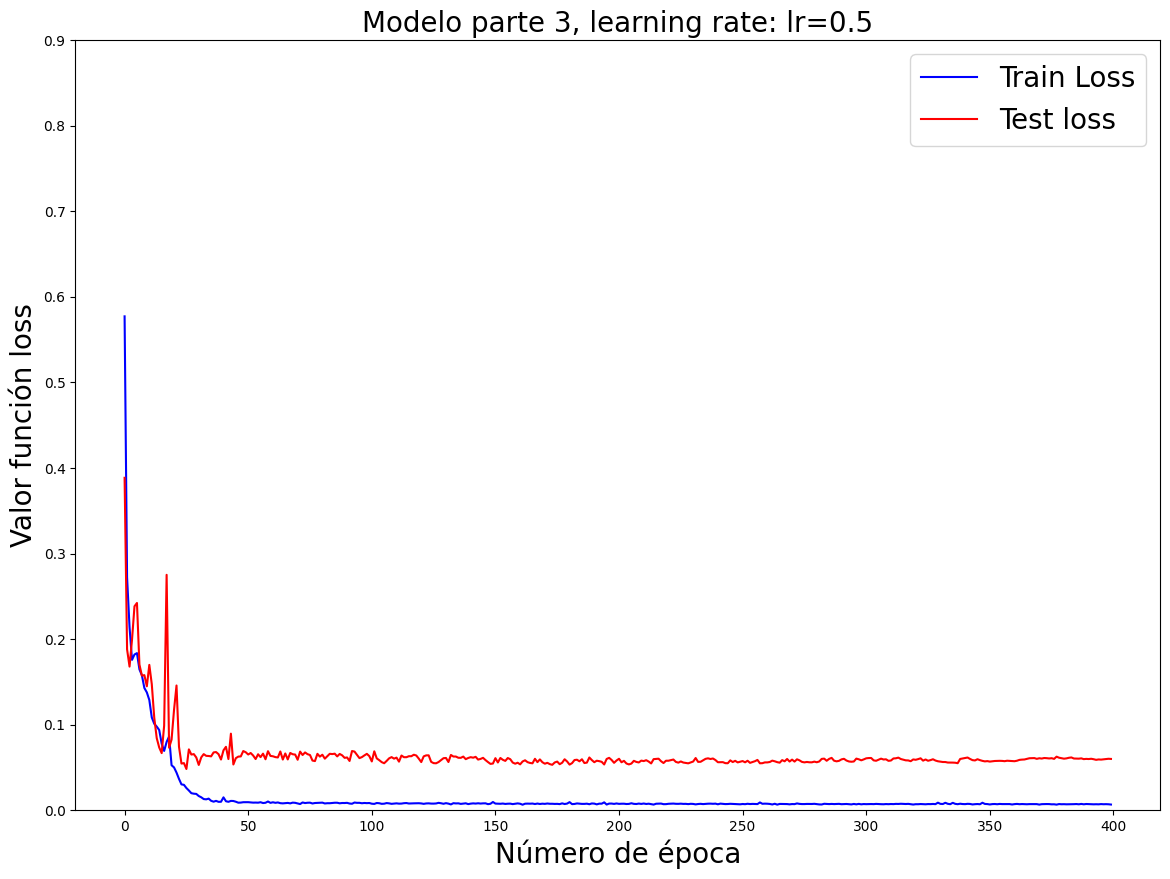

In [102]:
plot_epoch_vs_loss(data_list, "Modelo parte 3, learning rate: lr=0.5")

In [103]:
data_list = create_all(learning_rate=0.000001)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.89%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.65%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.49%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.49%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.734 |  Test. Acc: 36.67%
Epoch: 10 | Epoch T

Epoch: 86 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 87 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 88 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 89 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 91 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 92 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 93 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.49%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 94 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.25%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 95 | Epoch T

Epoch: 163 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 164 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 165 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 166 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 167 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.49%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 168 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 169 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 170 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 171 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.49%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 172

Epoch: 249 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 250 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 251 | Epoch Time: 0m 0s
	Train Loss: 0.727 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 252 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 253 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.49%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 254 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 255 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 256 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 257 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 258

Epoch: 334 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 335 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 336 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.41%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 337 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 338 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 339 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.73%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 340 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.81%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 341 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.65%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 342 | Epoch Time: 0m 0s
	Train Loss: 0.726 | Train Acc: 38.57%
	 Val. Loss: 0.733 |  Test. Acc: 36.67%
Epoch: 343

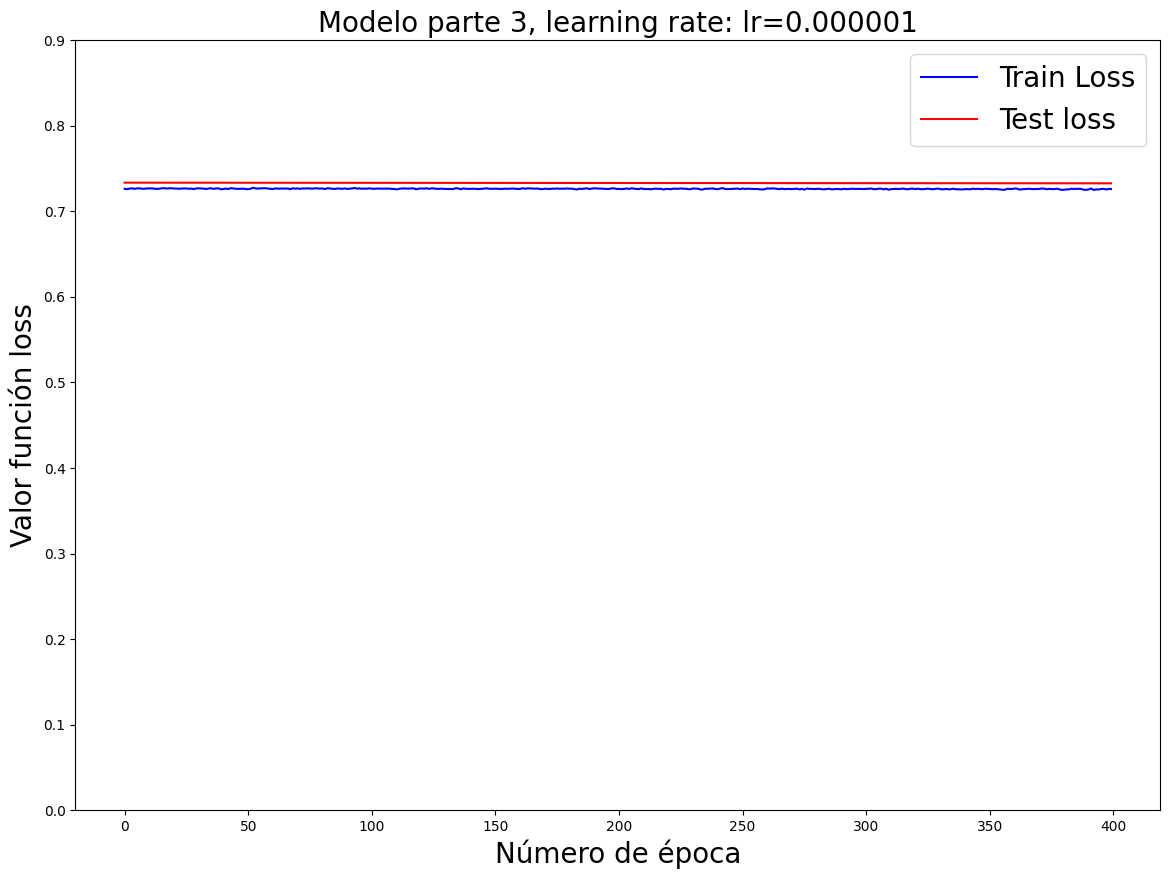

In [104]:
plot_epoch_vs_loss(data_list, "Modelo parte 3, learning rate: lr=0.000001")

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.